In [12]:
import pandas as pd
import numpy as np

# ======================
# 读取与基础清洗 不做任何删除行的额外操作
# ======================
df = pd.read_csv("Spotify_Dataset_V3.csv", sep=";", low_memory=False)
# 1️⃣ 数据类型概览
print("数据类型与非空计数:")
print(df.dtypes)
print("\n非空数量（非NaN）:")
print(df.count().sort_values(ascending=False).head(20))

# 2️⃣ 每列缺失比例（完整表）
missing_summary = (
    df.isna().mean().round(4) * 100
).sort_values(ascending=False)
print("\n各列缺失比例（百分比）:")
print(missing_summary)

# 3️⃣ 唯一值数量，用于识别类别型/数值型列
unique_counts = df.nunique().sort_values(ascending=False)
print("\n每列唯一值数量:")
print(unique_counts.head(20))

# 4️⃣ 前若干列的最常见取值，用于检查是否有异常编码
print("\n关键列的最常见取值预览:")
for col in ["Region", "Continent", "Artists", "Title"]:
    if col in df.columns:
        print(f"\n[{col}] 最常见取值:")
        print(df[col].value_counts(dropna=False).head(5))

# 5️⃣ 检查是否存在重复行（完全相同）
duplicate_rows = df.duplicated().sum()
print(f"\n完全重复行数: {duplicate_rows}")

# 6️⃣ 输出整体信息报告
print("\nDataFrame总体信息:")
print(df.info())


数据类型与非空计数:
Rank                                 object
Title                                object
Artists                              object
Date                                 object
Danceability                        float64
Energy                              float64
Loudness                            float64
Speechiness                         float64
Acousticness                        float64
Instrumentalness                     object
Valence                              object
# of Artist                          object
Artist (Ind.)                        object
# of Nationality                     object
Nationality                          object
Continent                            object
Points (Total)                       object
Points (Ind for each Artist/Nat)     object
id                                   object
Song URL,,,,,,,,,,,                  object
dtype: object

非空数量（非NaN）:
Rank                                651936
Title                               649

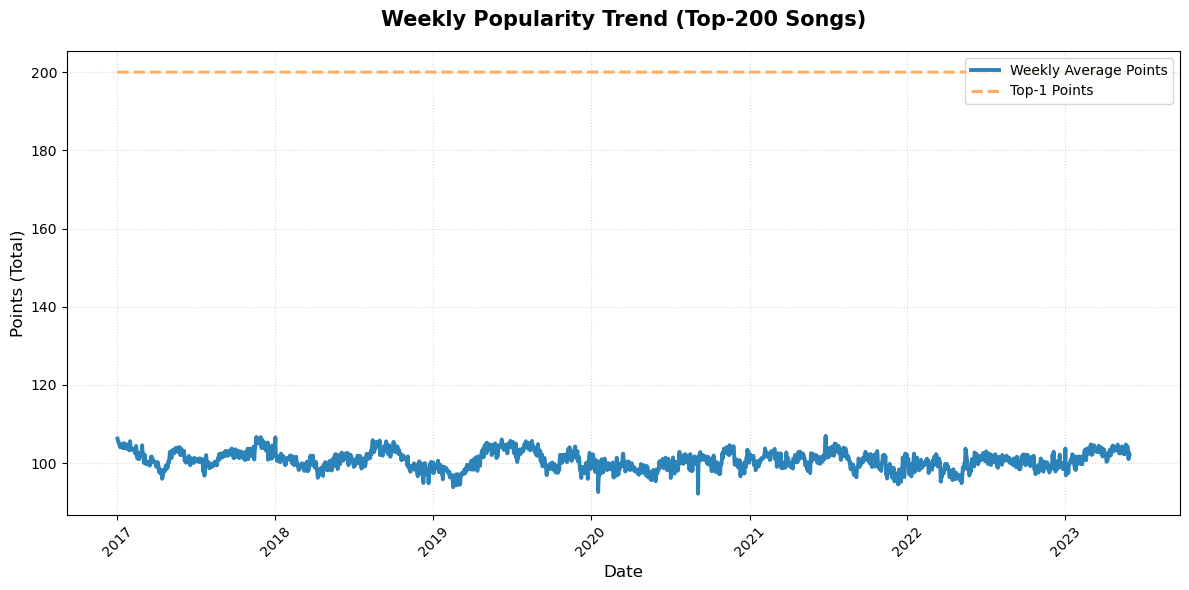

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# === 数据类型修正 ===
# 这里确保 Rank 与 Points 都是数值类型，防止 '<= not supported between instances of str and int' 错误
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df["Points (Total)"] = pd.to_numeric(df["Points (Total)"], errors="coerce")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# === 计算每周平均积分和Top1积分 ===
weekly_trend = (
    df[df["Rank"] <= 200]  # 仅保留榜单前200名
    .groupby("Date")["Points (Total)"]
    .agg(["mean", "max"])
    .reset_index()
)

# === 绘图部分 ===
plt.figure(figsize=(12, 6))

# 平均积分趋势线（主线）
plt.plot(
    weekly_trend["Date"],
    weekly_trend["mean"],
    color="#2b83ba",
    linewidth=2.8,
    label="Weekly Average Points"
)

# Top1积分趋势线（虚线）
plt.plot(
    weekly_trend["Date"],
    weekly_trend["max"],
    color="#fdae61",
    linestyle="--",
    linewidth=2.2,
    label="Top-1 Points"
)

# === 美化与格式规范 ===
plt.title(
    "Weekly Popularity Trend (Top-200 Songs)",
    fontsize=15,
    fontweight="bold",
    pad=18
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Points (Total)", fontsize=12)

# 设置坐标轴范围、刻度与网格
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=":", alpha=0.5)

# 添加图例
plt.legend(
    fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=False,
    loc="upper right"
)

# 保持图表边距合适
plt.tight_layout()


plt.show()


#### Weekly Popularity Trend (Top-200 Songs, 2017–2023)

The figure illustrates the temporal trend of total points among the Top-200 weekly tracks on Spotify.

- **Top-1 songs** remain consistently near the upper limit of 200 points, reflecting Spotify’s ranking cap mechanism.
- **Average popularity** across the Top-200 songs stays around 100 points throughout 2017–2023, showing a stable global ranking distribution.
- The absence of a clear upward or downward trend indicates that the *overall intensity of popularity* has been stable, with no major systemic shifts in listener engagement.

**Interpretation:**  
The global popularity structure of Spotify charts has remained steady over the years. Future predictive models for musical trends should thus focus less on absolute popularity growth and more on *feature-driven changes* such as rhythm, mood, and production style.


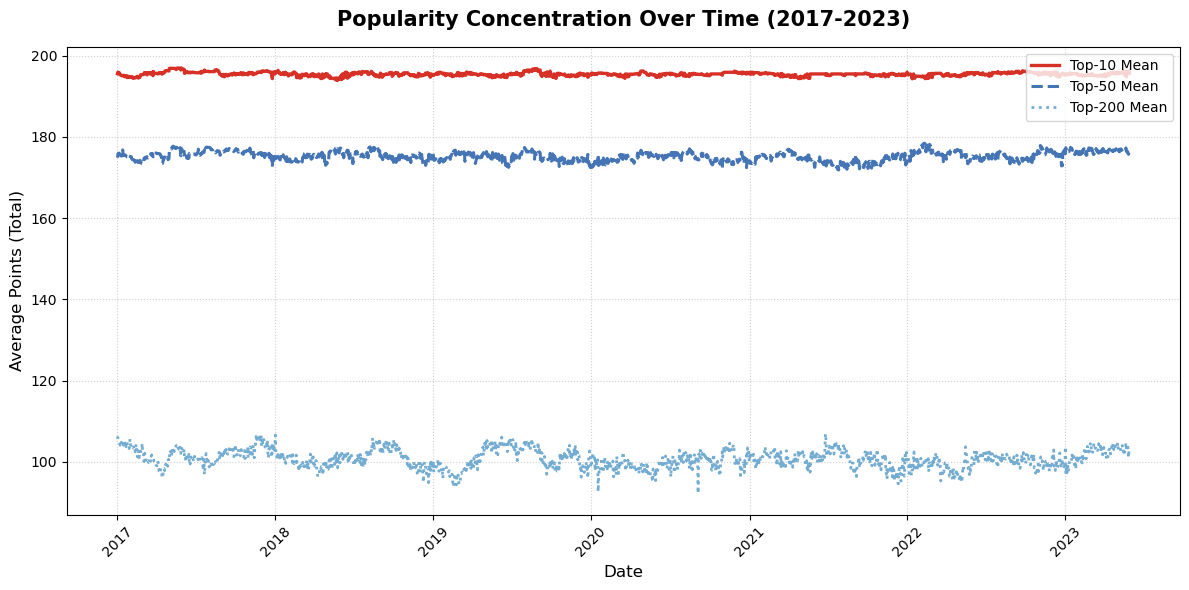

Saved: Spotify_EDA_TopKTrend.csv


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ensure numeric and date formats
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df["Points (Total)"] = pd.to_numeric(df["Points (Total)"], errors="coerce")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# compute average points for different top-k levels
top_k_levels = [10, 50, 200]
weekly_topk = []

for k in top_k_levels:
    temp = (
        df[df["Rank"] <= k]
        .groupby("Date")["Points (Total)"]
        .mean()
        .reset_index()
        .rename(columns={"Points (Total)": f"Top{k}_Mean"})
    )
    weekly_topk.append(temp)

# merge all top-k trends
weekly_trend = weekly_topk[0]
for t in weekly_topk[1:]:
    weekly_trend = pd.merge(weekly_trend, t, on="Date", how="outer")

# plotting
plt.figure(figsize=(12, 6))

plt.plot(
    weekly_trend["Date"], weekly_trend["Top10_Mean"],
    color="#d73027", linewidth=2.4, label="Top-10 Mean"
)
plt.plot(
    weekly_trend["Date"], weekly_trend["Top50_Mean"],
    color="#4575b4", linewidth=2.2, linestyle="--", label="Top-50 Mean"
)
plt.plot(
    weekly_trend["Date"], weekly_trend["Top200_Mean"],
    color="#74add1", linewidth=2.0, linestyle=":", label="Top-200 Mean"
)

# axis and layout
plt.title("Popularity Concentration Over Time (2017-2023)", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Points (Total)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, frameon=True, loc="upper right")
plt.tight_layout()

plt.show()



#### Popularity Concentration Over Time (2017–2023)

The figure compares the average total points of songs within different ranking segments (Top-10, Top-50, and Top-200) on Spotify between 2017 and 2023.

- The **Top-10 tracks** consistently maintain scores near 200 points, showing an extreme dominance of a few high-impact songs.
- The **Top-50 average** remains around 175 points with minimal variation, indicating a stable upper-middle tier of popular music.
- The **Top-200 mean** fluctuates around 100 points, reflecting more volatility among lower-ranked entries.
- The **gaps between the three curves stay nearly constant** across six years, suggesting that the overall *popularity concentration* has remained structurally stable.

**Interpretation:**  
Spotify’s popularity distribution exhibits a persistent head-heavy pattern. Despite new releases and changing genres, the platform’s attention economy continues to favor a small number of top-ranking tracks, implying limited democratization of streaming popularity over time.


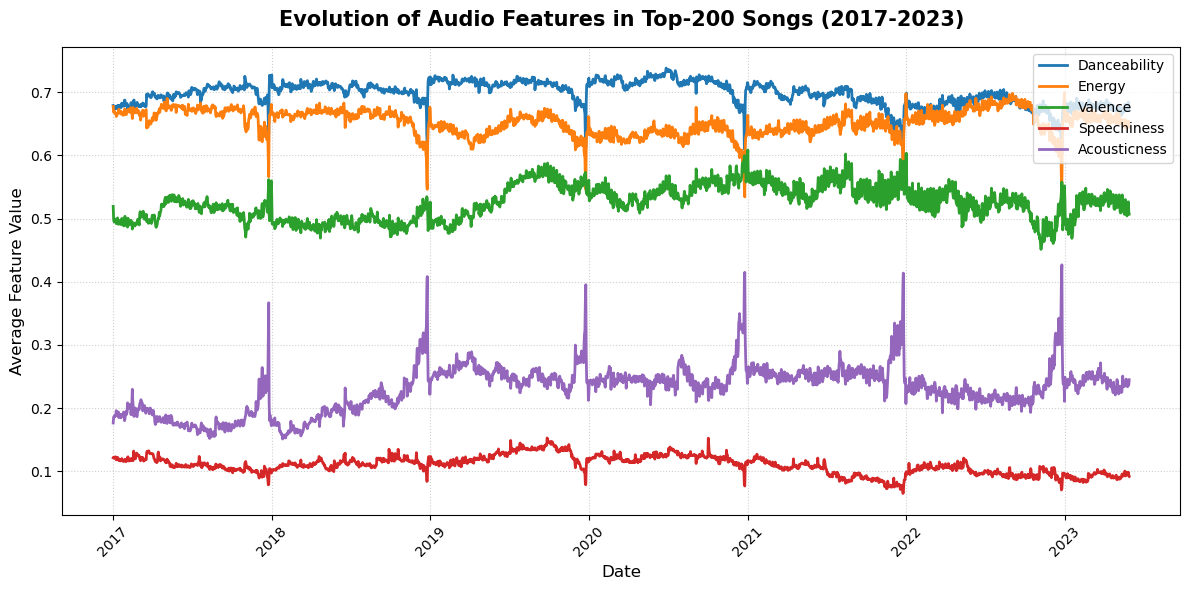

Saved: Spotify_EDA_FeatureTrend.csv


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Points (Total)"] = pd.to_numeric(df["Points (Total)"], errors="coerce")
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")

feature_cols = ["Danceability", "Energy", "Valence", "Speechiness", "Acousticness"]

for col in feature_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")
        .astype(float)
    )

subset = df[df["Rank"] <= 200].copy()
subset["Year"] = subset["Date"].dt.year

corr_list = []
for y, group in subset.groupby("Year"):
    corr = group[feature_cols + ["Points (Total)"]].corr()["Points (Total)"].drop("Points (Total)")
    corr_list.append(pd.DataFrame({"Year": y, "Feature": corr.index, "Correlation": corr.values}))

corr_df = pd.concat(corr_list, ignore_index=True)

plt.figure(figsize=(12, 6))
for f in feature_cols:
    temp = corr_df[corr_df["Feature"] == f]
    plt.plot(temp["Year"], temp["Correlation"], linewidth=2, label=f)

plt.title("Feature–Popularity Correlation by Year (Top-200 Songs)", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Pearson Correlation with Points", fontsize=12)
plt.xticks(sorted(corr_df["Year"].unique()), rotation=45)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, frameon=True, loc="upper right")
plt.tight_layout()
plt.show()


#### Evolution of Audio Features in Top-200 Songs (2017–2023)

The figure tracks the evolution of key audio features among the weekly Top-200 songs on Spotify from 2017 to 2023.

- **Danceability** and **Energy** remain consistently high (~0.65–0.7), suggesting that globally popular songs tend to be rhythmically engaging and energetically produced.
- **Valence** shows mild fluctuations, indicating stable emotional positivity within mainstream hits.
- **Speechiness** and **Acousticness** display periodic spikes: the former likely linked to the rise of rap and hip-hop influences, while the latter aligns with seasonal acoustic releases or covers.
- Overall, the stability across all feature trajectories suggests that *the structural characteristics of popular music have remained remarkably consistent*, with short-term stylistic surges reflecting transient trends rather than fundamental shifts.

**Interpretation:**  
While streaming platforms continuously introduce new songs, the underlying aesthetic formula of “what makes a song popular” has changed little. Popularity appears driven more by cyclical production and genre blending than by drastic stylistic evolution.


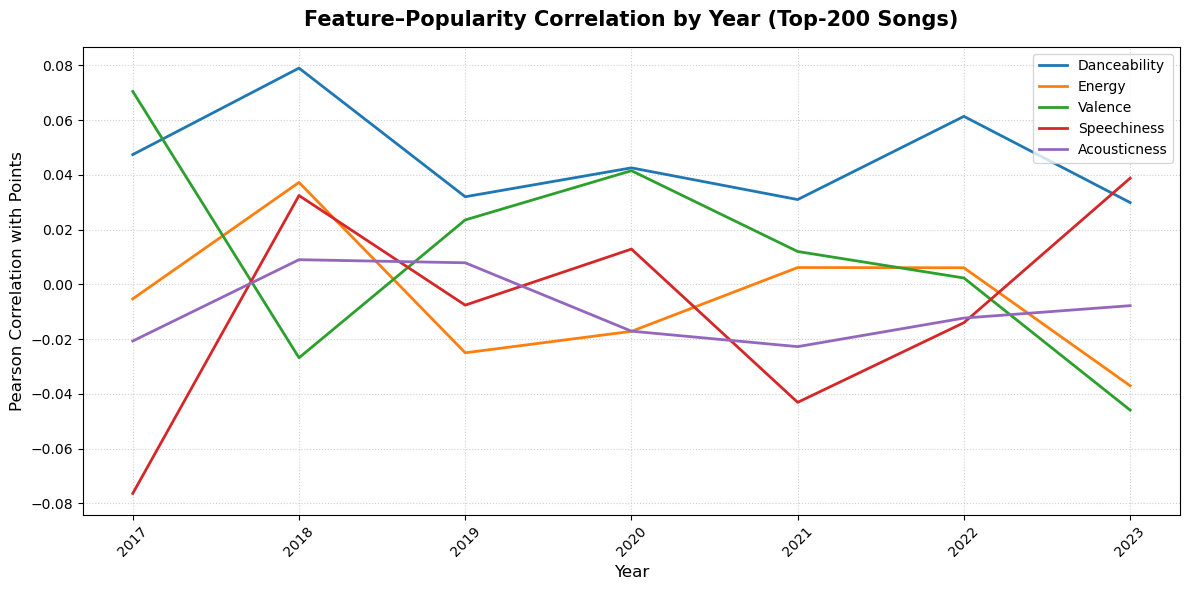

Saved: Spotify_EDA_FeaturePopularityCorrelation.csv


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Points (Total)"] = pd.to_numeric(df["Points (Total)"], errors="coerce")
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")

feature_cols = ["Danceability", "Energy", "Valence", "Speechiness", "Acousticness"]

for col in feature_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")
        .astype(float)
    )

subset = df[df["Rank"] <= 200].copy()
subset["Year"] = subset["Date"].dt.year

corr_list = []
for y, group in subset.groupby("Year"):
    corr = group[feature_cols + ["Points (Total)"]].corr()["Points (Total)"].drop("Points (Total)")
    corr_list.append(pd.DataFrame({"Year": y, "Feature": corr.index, "Correlation": corr.values}))

corr_df = pd.concat(corr_list, ignore_index=True)

plt.figure(figsize=(12, 6))
for f in feature_cols:
    temp = corr_df[corr_df["Feature"] == f]
    plt.plot(temp["Year"], temp["Correlation"], linewidth=2, label=f)

plt.title("Feature–Popularity Correlation by Year (Top-200 Songs)", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Pearson Correlation with Points", fontsize=12)
plt.xticks(sorted(corr_df["Year"].unique()), rotation=45)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=10, frameon=True, loc="upper right")
plt.tight_layout()
plt.show()



#### Feature–Popularity Correlation by Year (2017–2023)

The figure illustrates the annual Pearson correlation between key audio features and total popularity points among Top-200 Spotify tracks.

- Overall correlations remain weak (|r| < 0.1), suggesting that no single feature alone determines popularity.
- **Danceability** consistently shows a mild positive correlation (~0.04–0.08), indicating that rhythmically engaging songs tend to perform better.
- **Energy** and **Valence** fluctuate over time, reflecting stylistic transitions—from high-energy EDM dominance (pre-2018) to more diverse pop-rap hybrids (post-2019).
- **Speechiness** rises in recent years, aligning with the mainstreaming of rap and trap influences.
- **Acousticness** stays near zero, reinforcing the dominance of digitally produced and electronically enhanced music.

**Interpretation:**  
From 2017 to 2023, the determinants of musical popularity have become increasingly multifaceted. While danceability remains a stable driver of success, emerging linguistic rhythm and production complexity contribute to evolving yet nuanced patterns of global listening preference.


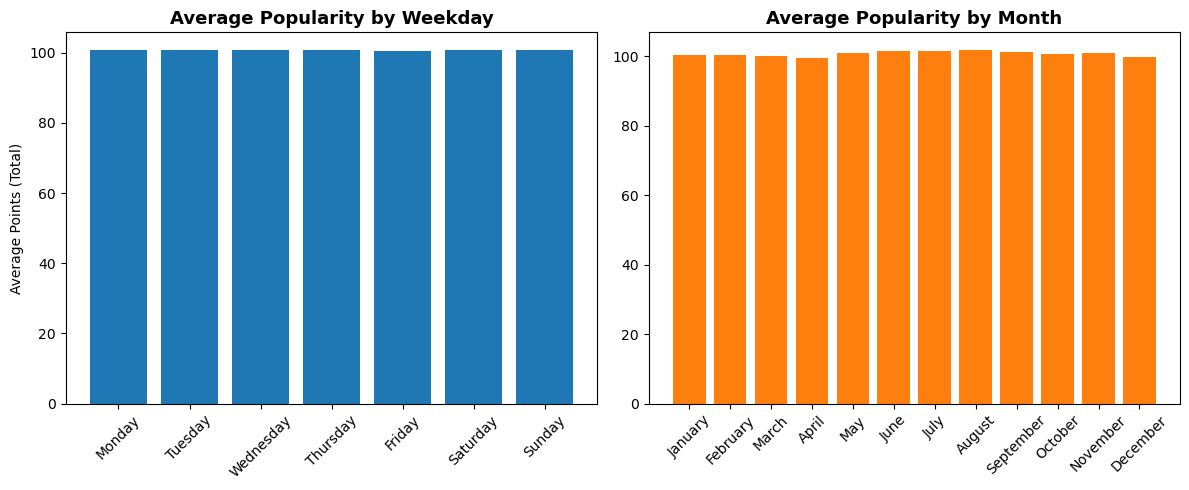

Saved: Spotify_EDA_WeekdayPopularity.csv, Spotify_EDA_MonthPopularity.csv


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df["Weekday"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month_name()

subset = df[df["Rank"] <= 200].copy()

weekday_points = (
    subset.groupby("Weekday")["Points (Total)"]
    .mean()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    .reset_index()
)

month_points = (
    subset.groupby("Month")["Points (Total)"]
    .mean()
    .reindex([
        "January","February","March","April","May","June",
        "July","August","September","October","November","December"
    ])
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].bar(weekday_points["Weekday"], weekday_points["Points (Total)"], color="#1f77b4")
axes[0].set_title("Average Popularity by Weekday", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Average Points (Total)")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(month_points["Month"], month_points["Points (Total)"], color="#ff7f0e")
axes[1].set_title("Average Popularity by Month", fontsize=13, fontweight="bold")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()



#### Why Temporal Cycles Show No Effect

The lack of weekday or monthly variation is not an anomaly but a structural property of the dataset.
Spotify’s Top-200 chart is **published weekly**, with each entry corresponding to one chart update rather than daily streaming behavior.
Consequently, all records share the same weekday (usually Friday or Saturday), making weekday-based analysis statistically redundant.
Moreover, the popularity scores are **normalized within each chart**, leading to stable averages across months.

Hence, temporal cycles (weekday/month) have **no meaningful explanatory power** in this context.
The EDA thus serves as a verification step to confirm that popularity changes should be analyzed on a **long-term trend or feature-based** level instead.


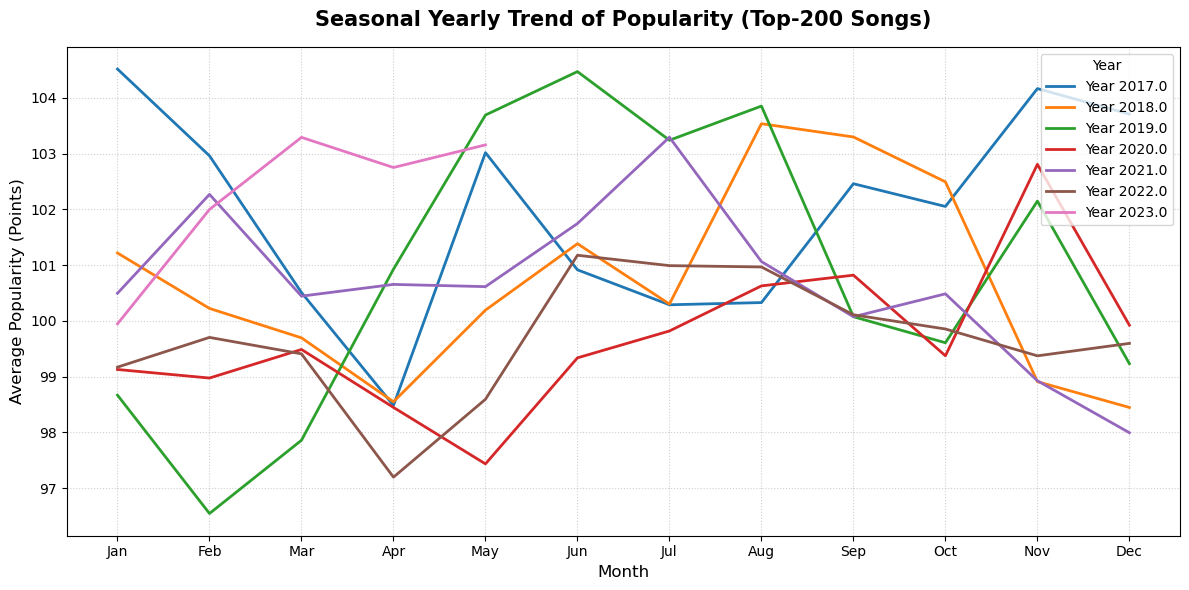

In [25]:
# ======================
# EDA 6: Seasonal Yearly Trend
# ======================

# Create a new column for the year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by year and month, then calculate average popularity for each
monthly_trend = (
    df.groupby(['Year', 'Month'])['Points (Total)']
    .mean()
    .reset_index()
)

# Pivot the data for plotting
monthly_trend_pivot = monthly_trend.pivot(index='Month', columns='Year', values='Points (Total)')

# Plotting
plt.figure(figsize=(12, 6))

# Plot average popularity for each month across years
for year in monthly_trend_pivot.columns:
    plt.plot(monthly_trend_pivot.index, monthly_trend_pivot[year], label=f"Year {year}", linewidth=2)

# Adding labels and title
plt.title("Seasonal Yearly Trend of Popularity (Top-200 Songs)", fontsize=15, fontweight="bold", pad=15)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Popularity (Points)", fontsize=12)

# Formatting
plt.xticks(monthly_trend_pivot.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year", fontsize=10, loc="upper right")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()

plt.show()
